# LAB 5. Hypothesis testing. Green taxi case

Test varios hypothesis about ridership volume and trip characteristics for green taxi trips in 2018-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [1]:
#import the modules
import pandas as pd
import geopandas as gpd
import urllib.request
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.path.exists('green_taxi/'):
    pass
else:
    os.makedirs('green_taxi')

for year in [2019,2020]:
    for month in range(1,13):
        urllib.request.urlretrieve ("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_%s-%s.parquet"%(str(year),str(month).rjust(2, '0')), 
                                    "green_taxi/green_tripdata_%s-%s.parquet"%(str(year),str(month).rjust(2, '0')))

In [3]:
dfTaxi = pd.read_parquet('green_taxi/')
dfTaxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2018-12-21 15:17:29,2018-12-21 15:18:57,N,1.0,264,264,5.0,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,2.0,1.0,NaN
1,2,2019-01-01 00:10:16,2019-01-01 00:16:32,N,1.0,97,49,2.0,0.86,6.0,0.5,0.5,0.00,0.0,NaN,0.3,7.30,2.0,1.0,NaN
2,2,2019-01-01 00:27:11,2019-01-01 00:31:38,N,1.0,49,189,2.0,0.66,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,1.0,1.0,NaN
3,2,2019-01-01 00:46:20,2019-01-01 01:04:54,N,1.0,189,17,2.0,2.68,13.5,0.5,0.5,2.96,0.0,NaN,0.3,19.71,1.0,1.0,NaN
4,2,2019-01-01 00:19:06,2019-01-01 00:39:43,N,1.0,82,258,1.0,4.53,18.0,0.5,0.5,0.00,0.0,NaN,0.3,19.30,2.0,1.0,NaN


In [4]:
#take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [5]:
#extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2018,2019,2020])]

In [6]:
#calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [7]:
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60) #avg trip speed in miles per hoiur

In [8]:
len(dfTaxi) #original number of records

8034961

In [9]:
#sanity filtering
dfTaxi = dfTaxi[(dfTaxi['Date']<=pd.to_datetime('6/30/2020')) & (dfTaxi.trip_distance < 100)
           & (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1)]
len(dfTaxi) #remaining records

7215288

In [10]:
#daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

In [11]:
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

In [12]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,12,0,2018-12-31,26,258.316667,60.45,14.040906
5,2019,1,1,2019-01-01,14806,204573.783333,58685.45,17.212015
10,2019,1,2,2019-01-02,19337,313291.066667,78826.38,15.096450
15,2019,1,3,2019-01-03,21199,354189.416667,85026.18,14.403510
20,2019,1,4,2019-01-04,22445,365281.183333,87954.88,14.447207


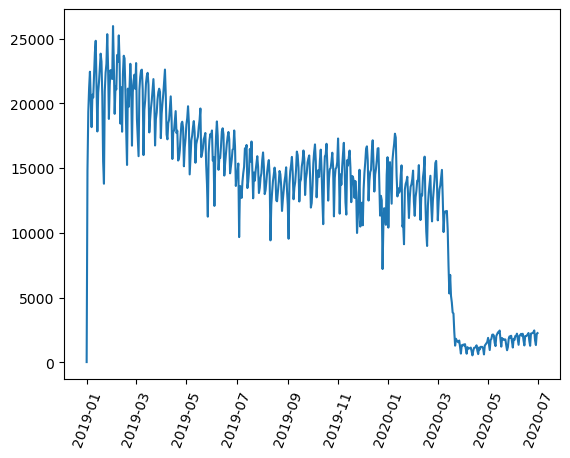

In [13]:
#ridership timeline - daily trip counts; seem to decline and particularly during the pandemics lockdown
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

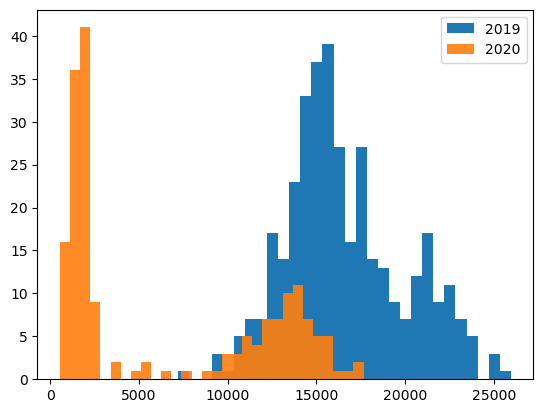

In [14]:
#histograms of daily counts in 2019 and 2018 - distributions look different
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'].values,bins=30,label='2019')
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.9,label='2020')
#plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.5,label='2020')
plt.legend()
plt.show()

In [15]:
## t-test between the 2019 and 2018 distributions
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [16]:
## K-S test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

KstestResult(statistic=0.0, pvalue=1.0)

So the hypothesis that 2018 and 2019 daily trip counts follow the same distributions can be rejected beyond any reasonable doubt

In [17]:
#For further analysis select the year 2019
dfTaxiDaily2019 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2019] #daily aggregates
dfTaxi2019 = dfTaxi.loc[dfTaxi['Year']==2019] #individual trips
(dfTaxiDaily2019['trip_count'].sum(),len(dfTaxi2019)) #total trip counts in either dataset

(6050571, 6050571)

## Example 1. Test if weekend ridership is different from weekday

In [18]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<=4
# t-test
stats.ttest_ind(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<=4]['trip_count'])

Ttest_indResult(statistic=-3.4042707657462894, pvalue=0.0007375120140568516)

In [19]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<=4
# KS-test
stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<=4]['trip_count'])

KstestResult(statistic=0.21198054818744475, pvalue=0.0020180944149611403)

Reject the hypothesis that weekends and weekdays follow the same ridership distribution at 95\% significance level

## Example 2. Test if trip speed, duration or distance follow log-normal distributions

<AxesSubplot:>

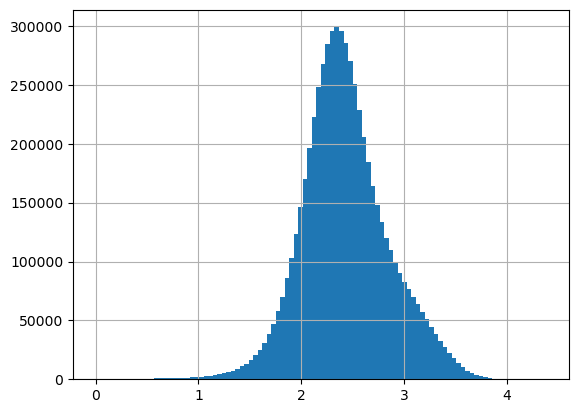

In [20]:
#analyze the overall speed distribution (plot on log-scale)
np.log(dfTaxi2019['speed']).hist(bins=100)

<AxesSubplot:>

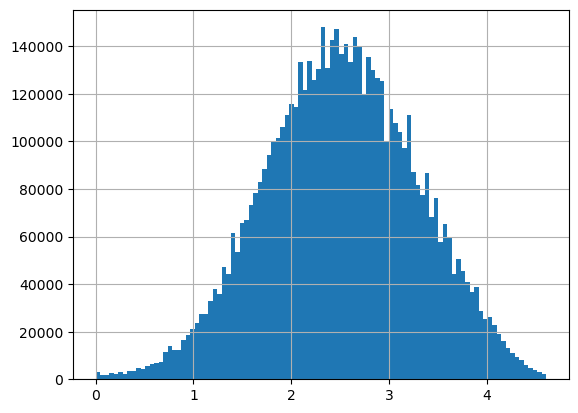

In [21]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_duration']).hist(bins=100)

<AxesSubplot:>

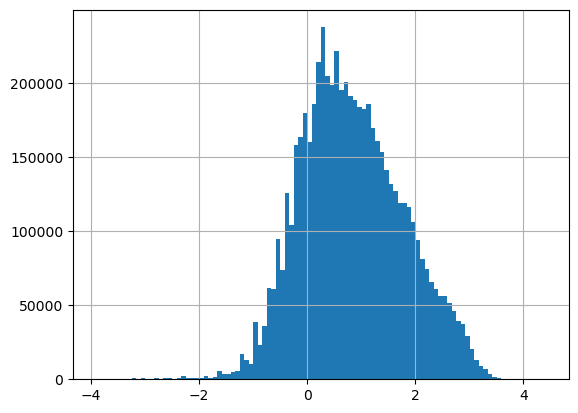

In [22]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_distance']).hist(bins=100)

In [23]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [24]:
# is log-speed normally distributed?
is_normal(np.log(dfTaxi2019['speed']))

KstestResult(statistic=0.041125044444147774, pvalue=0.0)

In [25]:
# is log-duration normally distributed?
is_normal(np.log(dfTaxi2019['trip_duration']))

KstestResult(statistic=0.009910669525470817, pvalue=0.0)

In [26]:
# is log-distance normally distributed?
is_normal(np.log(dfTaxi2019['trip_distance']))

KstestResult(statistic=0.038052087226787656, pvalue=0.0)

In [27]:
#so none of those quantities have log-normal distribution (rejecting with 99.9999...% confidence)

In [28]:
#what about daily average trip_count, duration, distance, speed?

In [29]:
is_normal(dfTaxiDaily2019['trip_count']) #does not look normal

KstestResult(statistic=0.08976513787910678, pvalue=0.0052161800054339475)

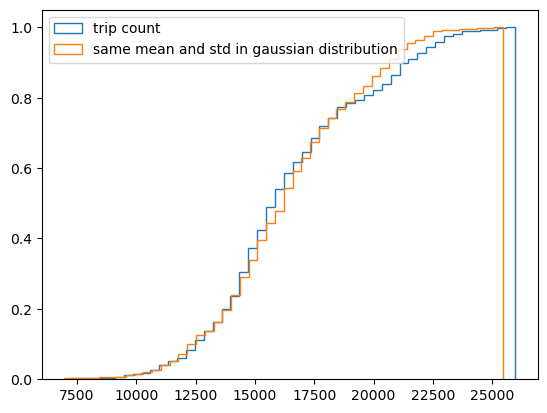

In [30]:
#visualize empiric CDF's for trip-counts
plt.hist(dfTaxiDaily2019['trip_count'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip count')
plt.hist(np.random.normal(dfTaxiDaily2019['trip_count'].mean(), dfTaxiDaily2019['trip_count'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [31]:
is_normal(np.log(dfTaxiDaily2019['trip_count'])) #but might be log-normal

KstestResult(statistic=0.05178617029731858, pvalue=0.27209665553065987)

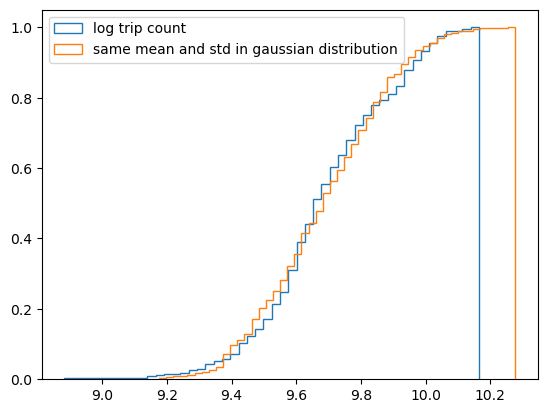

In [32]:
#visualize empiric CDF's for log trip-counts
plt.hist(np.log(dfTaxiDaily2019['trip_count'].values), 50, density=True, 
         histtype='step',cumulative=True,label='log trip count')
plt.hist(np.random.normal(np.log(dfTaxiDaily2019['trip_count']).mean(), np.log(dfTaxiDaily2019['trip_count']).std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [33]:
is_normal(dfTaxiDaily2019['trip_duration']) #could be normal

KstestResult(statistic=0.08627672246372531, pvalue=0.00819631097004777)

<AxesSubplot:>

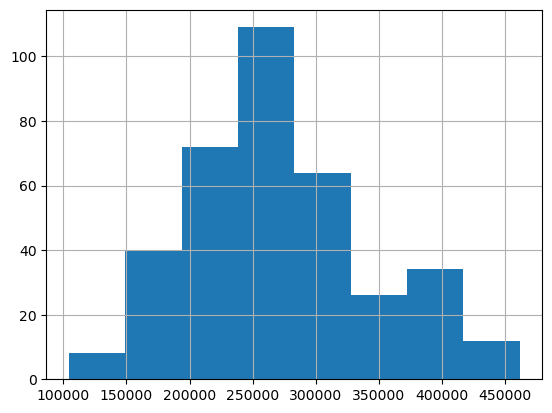

In [34]:
dfTaxiDaily2019['trip_duration'].hist(bins=8)

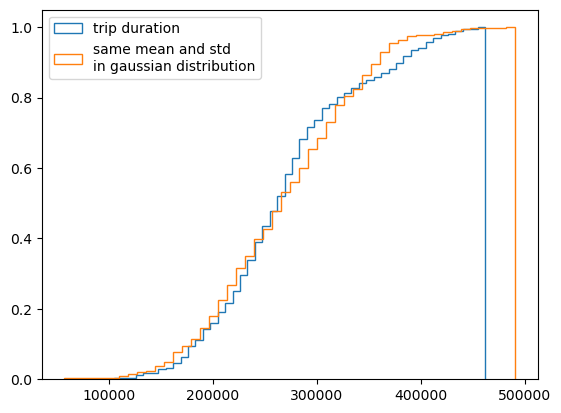

In [35]:
_ = plt.hist(dfTaxiDaily2019['trip_duration'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip duration')
_ = plt.hist(np.random.normal(dfTaxiDaily2019['trip_duration'].mean(), 
                              dfTaxiDaily2019['trip_duration'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std \nin gaussian distribution')
plt.legend(loc='upper left')

In [36]:
is_normal(dfTaxiDaily2019['trip_distance']) #does not look normal

KstestResult(statistic=0.17162133299223226, pvalue=7.188960711147288e-10)

In [37]:
is_normal(np.log(dfTaxiDaily2019['trip_distance'])) #but might be log-normal

KstestResult(statistic=0.12270218424241863, pvalue=3.0126880620963445e-05)

In [38]:
is_normal(dfTaxiDaily2019['speed']) #might be normal

KstestResult(statistic=0.0762848602607274, pvalue=0.02708299718490248)

In [39]:
is_normal(np.log(dfTaxiDaily2019['speed'])) #log-normal even more likely

KstestResult(statistic=0.06791069917206083, pvalue=0.0658566226345636)

## Homework assignment

## Task 1. Travel speed - hours of the day
Traffic and travel speed might vary throughout the day. Select the trips happening on Oct, 1, 2019. a) Compute average travel speed per each hour of the day and visuale as a bar plot. Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am, c) morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18)). Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95\% significance level?

In [40]:
dfTaxi_1 = dfTaxi[(dfTaxi['Date']==pd.to_datetime('10/01/2019'))]
len(dfTaxi_1)
dfTaxi_1.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,trip_duration,speed
4860421,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.5,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,1.516667,14.241758
4860623,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.0,...,1.0,1.0,0.0,2019-10-01,10,2019,1,0,10.450000,16.363636
4860661,2,2019-10-01 00:00:05,2019-10-01 00:05:50,N,1.0,256,37,1.0,1.21,6.5,...,1.0,1.0,0.0,2019-10-01,10,2019,1,0,5.750000,12.626087
4919805,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,13.933333,25.320574
4919806,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,4.450000,10.786517


In [41]:
dfTaxi_1['Hour'].unique()

array([ 0,  1,  2,  6,  7,  3,  4,  8,  5, 16, 10, 17, 11, 18, 12, 19, 13,
        9, 20, 14, 15, 21, 22, 23], dtype=int64)

In [42]:
dfTaxi_oct1 = dfTaxi_1.groupby(['Hour','Date']).\
            agg({'speed':'mean','lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'speed':'Avg_speed','lpep_pickup_datetime':'count'}).reset_index()

dfTaxi_oct1          


,Hour,Date,Avg_speed,count,trip_duration,trip_distance
0,0,2019-10-01,15.462158,214,2334.350000,668.85
1,1,2019-10-01,15.006791,127,1381.233333,385.41
2,2,2019-10-01,15.089092,72,782.450000,215.77
3,3,2019-10-01,16.959088,79,923.000000,318.19
4,4,2019-10-01,20.315675,86,1285.066667,507.86
5,5,2019-10-01,21.163462,126,2175.283333,849.78
6,6,2019-10-01,16.589186,250,5009.300000,1538.61
7,7,2019-10-01,13.306396,503,8854.566667,2105.64
8,8,2019-10-01,12.561804,733,12250.116667,2836.71
9,9,2019-10-01,12.717549,840,12839.400000,2979.73


Text(0, 0.5, 'Avg Speed')

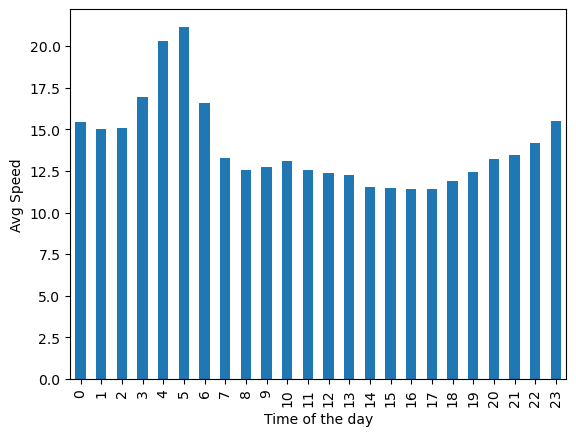

In [43]:
dfTaxi_oct1['Avg_speed'].plot.bar()
plt.xlabel('Time of the day')
plt.ylabel('Avg Speed')

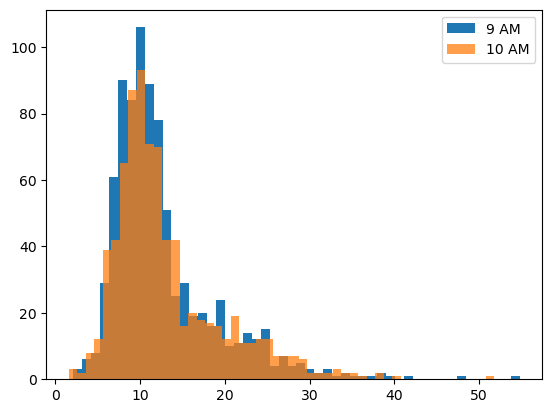

In [44]:
plt.hist(dfTaxi_1.loc[dfTaxi_1['Hour']==9]['speed'].values,bins=50,label='9 AM')
plt.hist(dfTaxi_1.loc[dfTaxi_1['Hour']==10]['speed'].values,bins=50,alpha = 0.75,label='10 AM')
plt.legend()
plt.show()

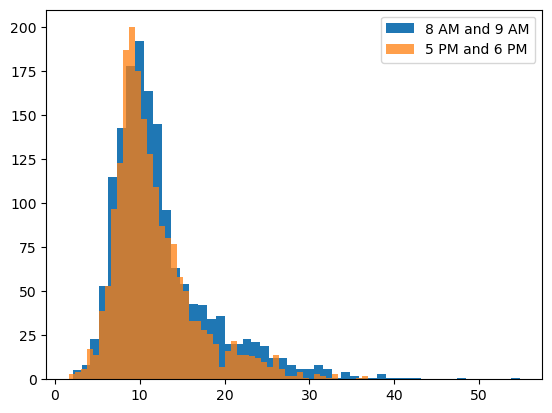

In [45]:
plt.hist(dfTaxi_1.loc[dfTaxi_1['Hour'].isin([8,9])]['speed'].values,bins=50,label='8 AM and 9 AM')
plt.hist(dfTaxi_1.loc[dfTaxi_1['Hour'].isin([17,18])]['speed'].values,bins=50,alpha= 0.75,label='5 PM and 6 PM')
plt.legend()
plt.show()

In [46]:
stats.ttest_ind(dfTaxi_1.loc[dfTaxi_1['Hour'].isin([8,9])]['speed'].values,dfTaxi_1.loc[dfTaxi_1['Hour'].isin([17,18])]['speed'].values)

Ttest_indResult(statistic=5.316218844376528, pvalue=1.1253493376433041e-07)

In [47]:
stats.ks_2samp(dfTaxi_1.loc[dfTaxi_1['Hour'].isin([8,9])]['speed'].values,dfTaxi_1.loc[dfTaxi_1['Hour'].isin([17,18])]['speed'].values)

KstestResult(statistic=0.06860517517057287, pvalue=0.0005164093592967348)

In [48]:
print(stats.ttest_ind(dfTaxi_1.loc[dfTaxi_1['Hour']==9]['speed'].values,dfTaxi_1.loc[dfTaxi_1['Hour']==10]['speed'].values))
print(stats.ks_2samp(dfTaxi_1.loc[dfTaxi_1['Hour']==9]['speed'].values,dfTaxi_1.loc[dfTaxi_1['Hour']==10]['speed'].values))

Ttest_indResult(statistic=-1.173277394807621, pvalue=0.24085674028299217)
KstestResult(statistic=0.04866545344252351, pvalue=0.2793212653142789)


In [49]:
## For a) we fail to reject our null hypothesis and for b) we reject our null hypothesis


## Task 2. Travel speed - days of the week
Traffic and travel speed also vary during different weekdays. a) Compute average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc); visualize those as a bar plot. Then compute average travel speed per each day of the year and perform a pairwise comparison between the distributions of the daily speed averages within different days of the week (i.e. distribution of all Mondays vs all Tuesdays etc). Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%. As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.

In [50]:
dfTaxi_DOW = dfTaxi.groupby(['DOW']).\
            agg({'speed':'mean','lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'speed':'Avg_speed','lpep_pickup_datetime':'count'}).reset_index()

dfTaxi_DOW['DOW'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace = True)
dfTaxi_DOW

,DOW,Avg_speed,count,trip_duration,trip_distance
0,Monday,12.652143,949142,1.546594e+07,3532488.88
1,Tuesday,12.361563,1026847,1.738974e+07,3869718.06
2,Wednesday,12.260450,1069009,1.819012e+07,4001042.72
3,Thursday,12.036005,1103858,1.905807e+07,4090320.07
4,Friday,11.945202,1150169,1.933259e+07,4138708.92
5,Saturday,12.975047,1045864,1.553675e+07,3707535.24
6,Sunday,13.775123,870399,1.259031e+07,3222507.31


Text(0, 0.5, 'Avg Speed')

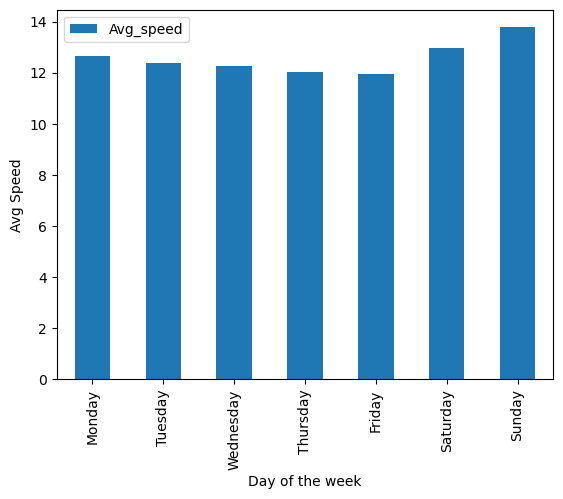

In [51]:
dfTaxi_DOW.plot(x= 'DOW', y= 'Avg_speed', kind = 'bar')
plt.xlabel('Day of the week')
plt.ylabel('Avg Speed')

In [52]:
dfTaxi_mon = dfTaxi.loc[dfTaxi['DOW']==0]

dfTaxi_monf=dfTaxi_mon.groupby(['Date']).\
           agg({'speed':'mean'})

print(dfTaxi_monf.head())

dfTaxi_tue = dfTaxi.loc[dfTaxi['DOW']==1]

dfTaxi_tuef=dfTaxi_tue.groupby(['Date']).\
           agg({'speed':'mean'})

print(dfTaxi_tuef.head())

dfTaxi_wed = dfTaxi.loc[dfTaxi['DOW']==2]

dfTaxi_wedf=dfTaxi_wed.groupby(['Date']).\
           agg({'speed':'mean'})

print(dfTaxi_wedf.head())

dfTaxi_thur = dfTaxi.loc[dfTaxi['DOW']==3]

dfTaxi_thurf=dfTaxi_thur.groupby(['Date']).\
           agg({'speed':'mean'})

print(dfTaxi_thurf.head())




                speed
Date                 
2018-12-31  12.742532
2019-01-07  12.899562
2019-01-14  12.670783
2019-01-21  14.499648
2019-01-28  12.884416
                speed
Date                 
2019-01-01  15.206464
2019-01-08  12.734347
2019-01-15  12.771798
2019-01-22  12.493349
2019-01-29  12.171845
                speed
Date                 
2019-01-02  13.611167
2019-01-09  12.750842
2019-01-16  12.707288
2019-01-23  12.793334
2019-01-30  12.248327
                speed
Date                 
2019-01-03  13.030264
2019-01-10  12.574574
2019-01-17  12.320522
2019-01-24  12.006299
2019-01-31  12.547993


In [53]:
dfTaxi_fri = dfTaxi.loc[dfTaxi['DOW']==4]

dfTaxi_frif=dfTaxi_fri.groupby(['Date']).\
           agg({'speed':'mean'})
dfTaxi_sat = dfTaxi.loc[dfTaxi['DOW']==5]

dfTaxi_satf=dfTaxi_sat.groupby(['Date']).\
           agg({'speed':'mean'})
dfTaxi_sun = dfTaxi.loc[dfTaxi['DOW']==6]

dfTaxi_sunf=dfTaxi_sun.groupby(['Date']).\
           agg({'speed':'mean'})

print(dfTaxi_frif.head(),dfTaxi_satf.head(),dfTaxi_sunf.head())


                speed
Date                 
2019-01-04  13.019425
2019-01-11  12.273503
2019-01-18  12.620665
2019-01-25  12.162293
2019-02-01  12.041629                 speed
Date                 
2019-01-05  13.504520
2019-01-12  13.389424
2019-01-19  13.562443
2019-01-26  13.285677
2019-02-02  12.967917                 speed
Date                 
2019-01-06  14.370097
2019-01-13  14.377475
2019-01-20  14.415864
2019-01-27  14.134573
2019-02-03  14.224107


In [54]:
stats.ks_2samp(dfTaxi_monf['speed'].values,dfTaxi_tuef['speed'].values)
    

KstestResult(statistic=0.1518987341772152, pvalue=0.3233499949874755)

In [55]:
First_=[dfTaxi_monf['speed'].values,dfTaxi_tuef['speed'].values,dfTaxi_wedf['speed'].values,dfTaxi_thurf['speed'].values,dfTaxi_frif['speed'].values,dfTaxi_satf['speed'].values,dfTaxi_sunf['speed'].values]
Second_=[dfTaxi_monf['speed'].values,dfTaxi_tuef['speed'].values,dfTaxi_wedf['speed'].values,dfTaxi_thurf['speed'].values,dfTaxi_frif['speed'].values,dfTaxi_satf['speed'].values,dfTaxi_sunf['speed'].values]
Day = dfTaxi_DOW['DOW'].unique()

df_1=[]

for i in range (len(First_)):
    df_2 = []
    for j in range (len(Second_)):
        p=stats.ks_2samp(First_[i],Second_[j])[1]
        print(Day[i],Day[j]," ",p)
        if i == j:
            df_2.append('-')
        elif p > 0.05:
            df_2.append('Keep')
        else :
            df_2.append('Reject')
    df_1.append(df_2) 
    

pd.DataFrame(df_1, columns= Day, index= Day)

Monday Monday   1.0
Monday Tuesday   0.3233499949874755
Monday Wednesday   0.0053236403865669175
Monday Thursday   2.5137210203789427e-05
Monday Friday   4.830061836112917e-06
Monday Saturday   0.001663756130657296
Monday Sunday   1.0390917206786235e-13
Tuesday Monday   0.3233499949874755
Tuesday Tuesday   1.0
Tuesday Wednesday   0.3513086987374669
Tuesday Thursday   0.022890984960121083
Tuesday Friday   0.0027093874600308972
Tuesday Saturday   2.1156774270717055e-06
Tuesday Sunday   6.700523682490068e-20
Wednesday Monday   0.0053236403865669175
Wednesday Tuesday   0.3513086987374669
Wednesday Wednesday   1.0
Wednesday Thursday   0.0749483529513129
Wednesday Friday   0.01922582971456673
Wednesday Saturday   2.6210938879986773e-08
Wednesday Sunday   1.14495882621505e-19
Thursday Monday   2.5137210203789427e-05
Thursday Tuesday   0.022890984960121083
Thursday Wednesday   0.0749483529513129
Thursday Thursday   1.0
Thursday Friday   0.8099828657091238
Thursday Saturday   3.066474928257846e

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Monday,-,Keep,Reject,Reject,Reject,Reject,Reject
Tuesday,Keep,-,Keep,Reject,Reject,Reject,Reject
Wednesday,Reject,Keep,-,Keep,Reject,Reject,Reject
Thursday,Reject,Reject,Keep,-,Keep,Reject,Reject
Friday,Reject,Reject,Reject,Keep,-,Reject,Reject
Saturday,Reject,Reject,Reject,Reject,Reject,-,Reject
Sunday,Reject,Reject,Reject,Reject,Reject,Reject,-


## Task 3. Trip speeds per borough.

For the day of Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup). Then compare the samples of the trip speeds in Brooklyn, Queens and Bronx on that day using t-test and ks-test (pairwise comparison). Fill two 3x3 pandas dataframes (one for t-test, one for ks-test) with p-values for each pair of boroughs. Can we reject the null hypothesis that speed mean/distributions within each pair of boroughs is is similar?

HINT: Download taxizone geojson from 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON' to define borough for each pickup taxi zone.

In [56]:
# download taxizone map
##file = 'taxizone.geojson'
##url = 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON'
##urllib.request.urlretrieve(url,file)

task3 = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
task3.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [57]:
task3= task3[task3['borough'].isin(['Brooklyn','Queens','Bronx'])]
task3['borough'].unique()

array(['Queens', 'Bronx', 'Brooklyn'], dtype=object)

In [58]:
dfTaxi_1.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'Date', 'Month', 'Year', 'DOW', 'Hour', 'trip_duration', 'speed'],
      dtype='object')

In [59]:
dfTaxi_1f = task3.merge(dfTaxi_1, left_on='location_i', right_on='PULocationID')
dfTaxi_1f.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,...,payment_type,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,trip_duration,speed
0,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",2,2019-10-01 03:25:24,2019-10-01 03:44:59,...,1.0,1.0,0.0,2019-10-01,10,2019,1,3,19.583333,34.805106
1,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",1,2019-10-01 14:04:26,2019-10-01 14:24:35,...,1.0,1.0,0.0,2019-10-01,10,2019,1,14,20.150000,4.168734
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",2,2019-10-01 15:22:16,2019-10-01 15:39:24,...,1.0,1.0,0.0,2019-10-01,10,2019,1,15,17.133333,5.813230
3,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",2,2019-10-01 22:31:16,2019-10-01 22:43:09,...,1.0,1.0,0.0,2019-10-01,10,2019,1,22,11.883333,8.987377
4,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",2,2019-10-01 11:49:00,2019-10-01 12:06:00,...,NaN,NaN,NaN,2019-10-01,10,2019,1,11,17.000000,12.635294


In [60]:
dfTaxi_1f['borough'].unique()

array(['Bronx', 'Queens', 'Brooklyn'], dtype=object)

In [61]:
NY_Boro = ['Brooklyn','Queens','Bronx']
df_5 = []
for i in NY_Boro:
    df_4 = []
    for j in NY_Boro:
        p=stats.ks_2samp(dfTaxi_1f[dfTaxi_1f['borough']==i]['speed'].values,dfTaxi_1f[dfTaxi_1f['borough']==j]['speed'].values)[1]
        print(i,j," ",p)
        if i == j:
            df_4.append('-')
        elif p > 0.05:
            df_4.append('Keep')
        else :
            df_4.append('Reject')
    df_5.append(df_4) 
    

pd.DataFrame(df_5, columns= NY_Boro, index= NY_Boro)


Brooklyn Brooklyn   1.0
Brooklyn Queens   7.55357853811378e-21
Brooklyn Bronx   1.4897166636991117e-37
Queens Brooklyn   7.55357853811378e-21
Queens Queens   1.0
Queens Bronx   6.976262147261574e-13
Bronx Brooklyn   1.4897166636991117e-37
Bronx Queens   6.976262147261574e-13
Bronx Bronx   1.0


,Brooklyn,Queens,Bronx
Brooklyn,-,Reject,Reject
Queens,Reject,-,Reject
Bronx,Reject,Reject,-


In [62]:
NY_Boro = ['Brooklyn','Queens','Bronx']
df_5 = []
for i in NY_Boro:
    df_4 = []
    for j in NY_Boro:
        p=stats.ttest_ind(dfTaxi_1f[dfTaxi_1f['borough']==i]['speed'].values,dfTaxi_1f[dfTaxi_1f['borough']==j]['speed'].values)[1]
        print(i,j," ",p)
        if i == j:
            df_4.append('-')
        elif p > 0.05:
            df_4.append('Keep')
        else :
            df_4.append('Reject')
    df_5.append(df_4) 
    

pd.DataFrame(df_5, columns= NY_Boro, index= NY_Boro)

Brooklyn Brooklyn   1.0
Brooklyn Queens   7.438515878530461e-16
Brooklyn Bronx   3.834651639139838e-36
Queens Brooklyn   7.438515878530461e-16
Queens Queens   1.0
Queens Bronx   1.058710250850341e-11
Bronx Brooklyn   3.834651639139838e-36
Bronx Queens   1.058710250850341e-11
Bronx Bronx   1.0


,Brooklyn,Queens,Bronx
Brooklyn,-,Reject,Reject
Queens,Reject,-,Reject
Bronx,Reject,Reject,-


# Task 4. Ridership drop during pandemics
No doubt that 2020 saw a large drop in ridership but how can we assess it? Keep in mind that we don't have the full year, the drop just started in March and there is also a general decline in taxi ridership, so we need a way to distinguish pandemics-related drop from the general trend. In order to account for it, normalize 2020 daily ridership data by the same day's 30-days rolling average (15 days before/after to smoothen out the effect of weekly variations within the baseline) in 2019, and compare the daily ratios of ridership after the shelter in place order (Mar 20th till June, 30th, 2020) and before (Jan, 16-Mar, 20th, 2020). Report p-values of ks-test and t-test. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before? For comparison and to provide a baseline for evaluating results of the hypothesis testing perform the same analysis for the same periods of 2019. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2019 is the same as before?

In [63]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,12,0,2018-12-31,26,258.316667,60.45,14.040906
5,2019,1,1,2019-01-01,14806,204573.783333,58685.45,17.212015
10,2019,1,2,2019-01-02,19337,313291.066667,78826.38,15.096450
15,2019,1,3,2019-01-03,21199,354189.416667,85026.18,14.403510
20,2019,1,4,2019-01-04,22445,365281.183333,87954.88,14.447207


In [64]:
dfTaxiDaily_2019=dfTaxiDaily[dfTaxiDaily['Year']==2019]
dfTaxiDaily_2019['Moving_AVG'] = dfTaxiDaily_2019['trip_count'].rolling(window=30,min_periods=1).mean()
dfTaxiDaily_2019.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Moving_AVG
5,2019,1,1,2019-01-01,14806,204573.783333,58685.45,17.212015,14806.000000
10,2019,1,2,2019-01-02,19337,313291.066667,78826.38,15.096450,17071.500000
15,2019,1,3,2019-01-03,21199,354189.416667,85026.18,14.403510,18447.333333
20,2019,1,4,2019-01-04,22445,365281.183333,87954.88,14.447207,19446.750000
24,2019,1,5,2019-01-05,20196,281748.833333,71442.58,15.214100,19596.600000


In [65]:
len(dfTaxiDaily_2019)

365

In [66]:
dfTaxiDaily_2020=dfTaxiDaily[dfTaxiDaily['Year']==2020]
dfTaxiDaily_2020.reset_index(inplace=True,drop=True)
dfTaxiDaily_2020.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2020,1,2,2020-01-01,10410,146795.583333,42825.83,17.504272
1,2020,1,3,2020-01-02,14440,241500.683333,61940.19,15.388824
2,2020,1,4,2020-01-03,15463,252003.183333,62165.15,14.801039
3,2020,1,5,2020-01-04,13797,205190.250000,54313.63,15.881933
4,2020,1,6,2020-01-05,12255,176122.633333,49472.43,16.853858


In [67]:
dfTaxiDaily_2020['Moving_AVG']=dfTaxiDaily_2019['Moving_AVG']
dfTaxiDaily_2020['RATIO']=dfTaxiDaily_2020['trip_count']/dfTaxiDaily_2020['Moving_AVG']
dfTaxiDaily_2020.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Moving_AVG,RATIO
0,2020,1,2,2020-01-01,10410,146795.583333,42825.83,17.504272,NaN,NaN
1,2020,1,3,2020-01-02,14440,241500.683333,61940.19,15.388824,19545.857143,0.738775
2,2020,1,4,2020-01-03,15463,252003.183333,62165.15,14.801039,20586.642857,0.751118
3,2020,1,5,2020-01-04,13797,205190.250000,54313.63,15.881933,20453.476190,0.674555
4,2020,1,6,2020-01-05,12255,176122.633333,49472.43,16.853858,20865.607143,0.587330


In [68]:
startdate2020 = pd.to_datetime("2020-01-16").date()
enddate2020 = pd.to_datetime("2020-03-21").date()

sb_2020 = dfTaxiDaily_2020[(dfTaxiDaily_2020['Date'] > startdate2020) & (dfTaxiDaily_2020['Date'] < enddate2020)]
sb_2020.head()


,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Moving_AVG,RATIO
16,2020,1,4,2020-01-17,15214,240713.216667,52351.22,13.049027,20344.300000,0.747826
17,2020,1,5,2020-01-18,10488,141599.050000,34289.00,14.529335,20964.529412,0.500274
18,2020,1,6,2020-01-19,10675,141949.400000,37705.01,15.937373,20661.583333,0.516659
19,2020,1,0,2020-01-20,9125,121485.016667,30461.45,15.044547,21201.800000,0.430388
20,2020,1,1,2020-01-21,13335,212255.633333,47770.80,13.503755,19446.750000,0.685719


In [69]:
startdate_covid = pd.to_datetime("2020-03-20").date()
enddate_covid = pd.to_datetime("2020-06-30").date()

sa_2020 = dfTaxiDaily_2020[(dfTaxiDaily_2020['Date'] > startdate_covid) & (dfTaxiDaily_2020['Date'] < enddate_covid)]

sa_2020.head()


,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Moving_AVG,RATIO
80,2020,3,5,2020-03-21,2349,30202.250000,9328.71,18.532480,20194.433333,0.116319
81,2020,3,6,2020-03-22,1294,16882.766667,5687.62,20.213346,21265.033333,0.060851
82,2020,3,0,2020-03-23,1824,25327.583333,8155.56,19.320185,20771.966667,0.087811
83,2020,3,1,2020-03-24,1698,23039.216667,7174.57,18.684411,20484.100000,0.082894
84,2020,3,2,2020-03-25,1600,21892.616667,7192.78,19.712893,20491.566667,0.078081


In [70]:
stats.ttest_ind(sb_2020['RATIO'].values,sa_2020['RATIO'].values)

Ttest_indResult(statistic=34.19259027747695, pvalue=2.922880841984526e-76)

In [71]:
stats.ks_2samp(sb_2020['RATIO'].values,sa_2020['RATIO'].values)

KstestResult(statistic=1.0, pvalue=4.410211258303491e-47)